In [494]:
import mne, os
from signal_processing.pre_process import *
from basic.arrange_data import read_files, create_results_folders
import numpy as np
from cmath import nan
import matplotlib.pyplot as plt
import pandas as pd

mne.set_log_level('error')

In [549]:
exp_folder = r"Auditory Oddball/10 weeks" # in case you want to just type the dir here
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')

raw_folder = r"Data/Raw/OKTOS/"
clean_folder = r"Data/Clean/OKTOS"
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)

results_foldername = r"Results/OKTOS"
exp_condition = r"AO_T07"

file_dirs, subject_names = read_files(dir_inprogress,".bdf")

Files in folder: 27


In [550]:
from sys import prefix
from mne.preprocessing import peak_finder
%matplotlib inline

def find_all_peaks(evoked_obj,epochs,thresh=None,subject_name='',verbose=False,plot=False):
    time_coef = 1e3
    amplitude_coef= 1e6

    evoked_data = evoked_obj.data[0]
    evoked_time = evoked_obj.times*time_coef

    # Use peak_finder to find only the peaks from the signal
    maxpeak_locs, maxpeak_mags = peak_finder(evoked_data,thresh=None,extrema=1)
    minpeak_locs, minpeak_mags = peak_finder(evoked_data,thresh=None,extrema=-1)

    # Calculate the time from the samples
    maxpeak_locs = (maxpeak_locs/epochs.info['sfreq'])*time_coef-200
    minpeak_locs = (minpeak_locs/epochs.info['sfreq'])*time_coef-200

    # Find the closest value from the signal time array
    minpeak_times = [None]*len(minpeak_locs)
    maxpeak_times = [None]*len(maxpeak_locs)
    for i,loc in enumerate(minpeak_locs):
        difference_array = np.absolute(evoked_time-loc)
        minpeak_times[i] = evoked_time[difference_array.argmin()]
    for i,loc in enumerate(maxpeak_locs):
        difference_array = np.absolute(evoked_time-loc)
        maxpeak_times[i] = evoked_time[difference_array.argmin()]

    # Convert amplitudes to right units
    maxpeak_mags = maxpeak_mags*amplitude_coef
    minpeak_mags = minpeak_mags*amplitude_coef

    if verbose == True:
        print('max peaks\ntimes:',maxpeak_times,'mag:',maxpeak_mags)
        print('min peaks\ntimes:',minpeak_times,'mag:',minpeak_mags)
    if plot == True:
        plt.figure(figsize=(8,3))
        plt.suptitle('All the detected peaks ({})'.format(subject_name))
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (uV)')
        plt.grid(which='major',axis='y',linewidth = 0.15)
        plt.xticks(np.arange(-200, 801, step=100))
        plt.xlim([-200,800])
        plt.plot(evoked_time,evoked_data*amplitude_coef,linewidth=0.6,color='black')
        plt.plot(maxpeak_locs, maxpeak_mags, marker='*', linestyle='None', color='r')
        plt.plot(minpeak_locs, minpeak_mags, marker='*', linestyle='None', color='b')
        
        plt.show()

    return minpeak_times,minpeak_mags,maxpeak_times,maxpeak_mags

def identify_erps(evoked_obj,erp_wins,minpeak_times,minpeak_mags,maxpeak_times,maxpeak_mags,subject_name='',verbose=False,plot=False,savefig=False):
    # Pre-define variables
    erp_peaks = {}
    not_erp_peaks = {}
    erp_times = []
    erp_mags = []
    all_peak_times = np.concatenate([minpeak_times,maxpeak_times])
    all_peak_mags = np.concatenate([minpeak_mags,maxpeak_mags])
    time_coef = 1e3
    amplitude_coef= 1e6

    evoked_data = evoked_obj.data[0]
    evoked_time = evoked_obj.times*time_coef

    # Check whether any of the pre-defined ERP time windows match with any of the peaks
    for ie, erp in enumerate(erp_wins):
        erp_name = list(erp_wins.keys())[ie]
        tminmax = erp_wins[erp][0:2]
        extremas = erp_wins[erp][-1]
        
        # If the ERP in interest positive, then check in time window and add the peak to ERP dictionary, and vice versa
        if extremas == 1:
            for idx, timepoint in enumerate(maxpeak_times):
                if tminmax[0] <= timepoint <= tminmax[1]:
                    if erp_name not in list(erp_peaks.keys()):
                        erp_peaks[erp_name] = [timepoint,maxpeak_mags[idx]]
                        erp_times.append(timepoint)
                        erp_mags.append(maxpeak_mags[idx])
                    else:
                        if maxpeak_mags[idx] > erp_peaks[erp_name][1]:
                            erp_peaks[erp_name] = [timepoint,maxpeak_mags[idx]]
                            erp_times.append(timepoint)
                            erp_mags.append(maxpeak_mags[idx])
        else:
            for idx, timepoint in enumerate(minpeak_times):
                if tminmax[0] <= timepoint <= tminmax[1]:
                    if erp_name not in list(erp_peaks.keys()):
                        erp_peaks[erp_name] = [timepoint,minpeak_mags[idx]]
                        erp_times.append(timepoint)
                        erp_mags.append(minpeak_mags[idx])
                    else:
                        if minpeak_mags[idx] < erp_peaks[erp_name][1]:
                            erp_peaks[erp_name] = [timepoint,minpeak_mags[idx]]
                            erp_times.append(timepoint)
                            erp_mags.append(minpeak_mags[idx])

    # Create a dictionary for all the peaks which did not get classified as ERPs
    not_erp_times = list(set(all_peak_times) - set(erp_times))
    not_erp_mags = list(set(all_peak_mags) - set(erp_mags))
    for idx in range(len(not_erp_times)):
        not_erp_peaks['N/A peak '+str(idx)] = [not_erp_times[idx],not_erp_mags[idx]]

    if verbose == True:
        print('ERPs\n',erp_peaks)
        print('Other peaks\n',not_erp_peaks)

    if plot == True:
        plt.figure(figsize=(8,3))
        plt.suptitle('Event-related potentials ({})'.format(subject_name))
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (uV)')
        plt.xlim([-200,800])
        plt.plot(evoked_time,evoked_data*amplitude_coef,linewidth=0.6,color='black')
        plt.grid(which='major',axis='y',linewidth = 0.15)
        plt.xticks(np.arange(-200, 801, step=100))
        plt.xlim([-200,800])
        for ie, erp_name in enumerate(erp_peaks):
            #print(ie,erp_name,erp_peaks[erp_name])
            if 'N' in erp_name:
                color = 'b'
            elif 'P' in erp_name:
                color = 'r'
            else:
                color = 'g'
            plt.plot(erp_peaks[erp_name][0], erp_peaks[erp_name][1], marker='*', linestyle='None', color=color)
            plt.annotate(erp_name, (erp_peaks[erp_name][0]+15,erp_peaks[erp_name][1]-0.15))
        if savefig == True:
            plt.savefig(fname='{}/ERP plots/{}_erpfig.png'.format(results_foldername,subject_name)) # add ERP plots to precreation function
        plt.show()
    
    return erp_peaks, not_erp_peaks

def erp_dict_to_df(erp_peaks,erp_wins,subject_name):
    df = pd.DataFrame(erp_peaks)
    df_erps_lat = pd.DataFrame(index=list(erp_wins.keys()))
    df_erps_amp = pd.DataFrame(index=list(erp_wins.keys()))

    df_erps_lat[subject_name] = df.loc[0]
    df_erps_amp[subject_name] = df.loc[1]

    df_erps_lat = df_erps_lat.T.add_suffix(' latency')
    df_erps_amp = df_erps_amp.T.add_suffix(' amplitude')

    df_erps = pd.concat([df_erps_lat,df_erps_amp],axis=1)

    return df_erps


Files in folder: 27


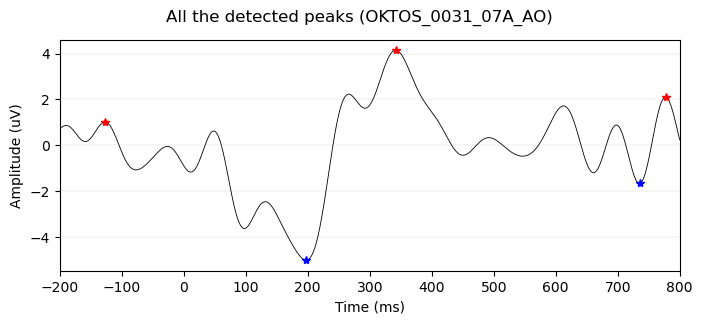

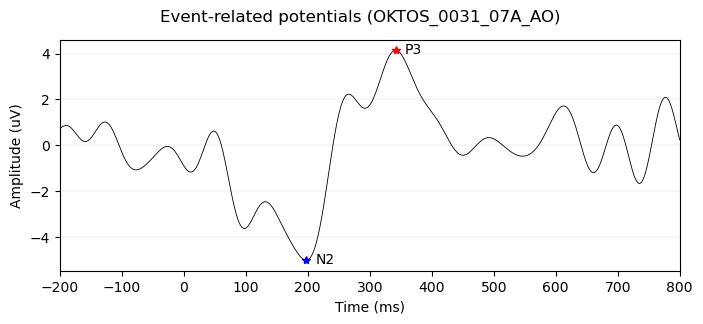

ERPs have been found and added to the dataframe for OKTOS_0031_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438


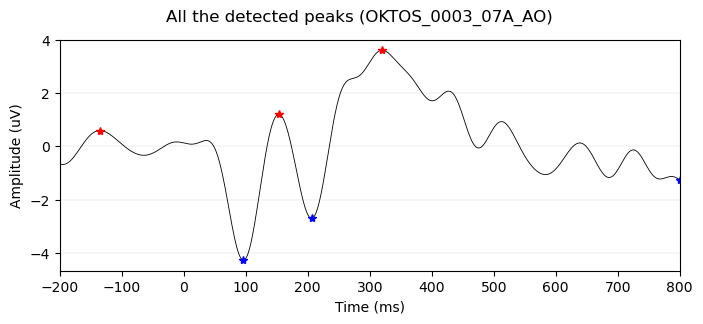

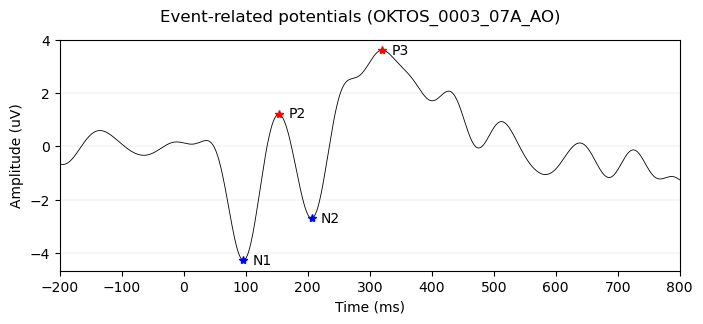

ERPs have been found and added to the dataframe for OKTOS_0003_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869


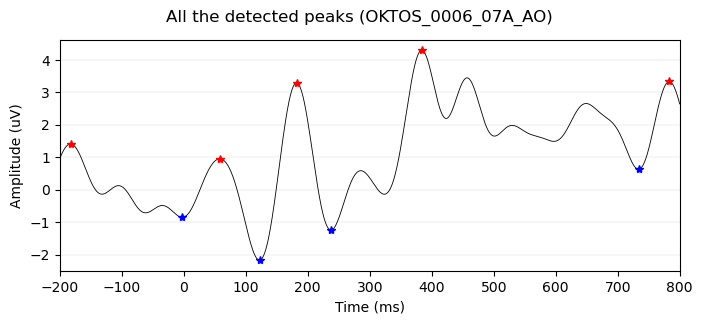

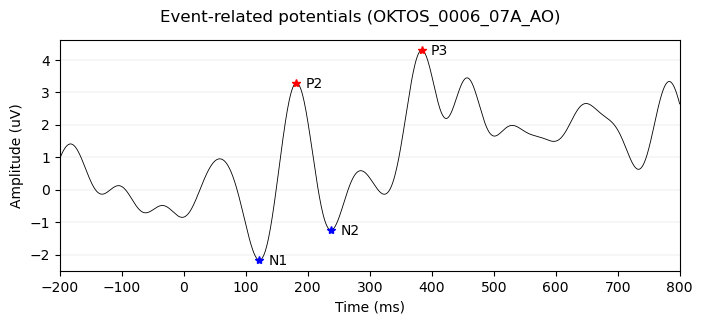

ERPs have been found and added to the dataframe for OKTOS_0006_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155


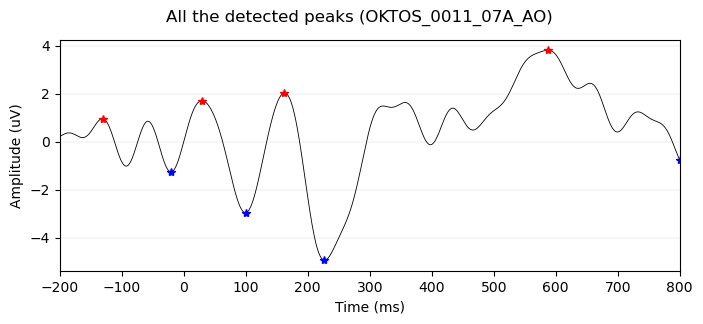

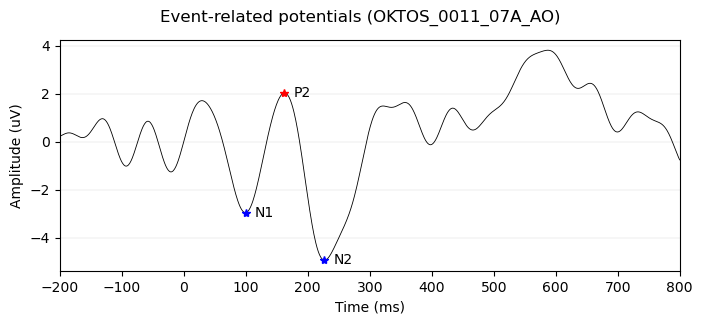

ERPs have been found and added to the dataframe for OKTOS_0011_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN


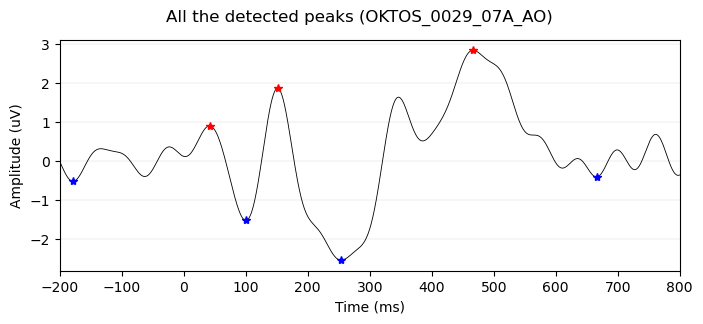

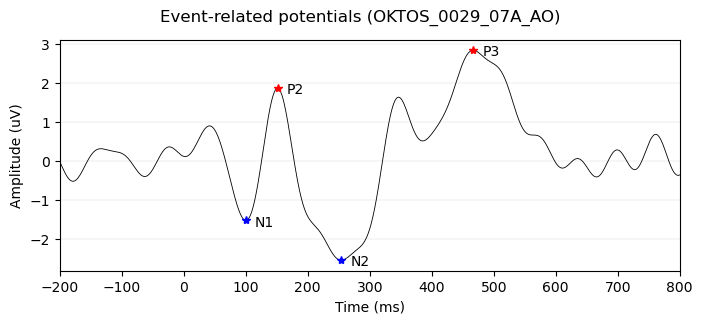

ERPs have been found and added to the dataframe for OKTOS_0029_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553


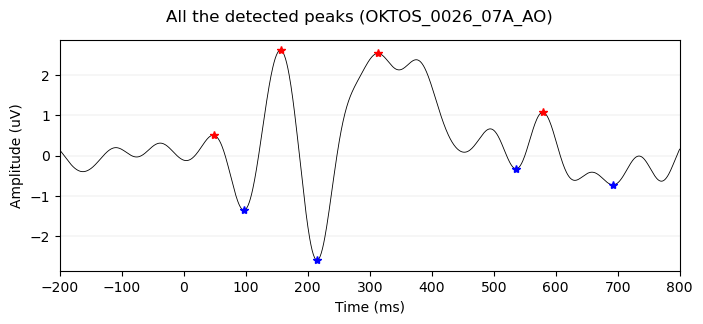

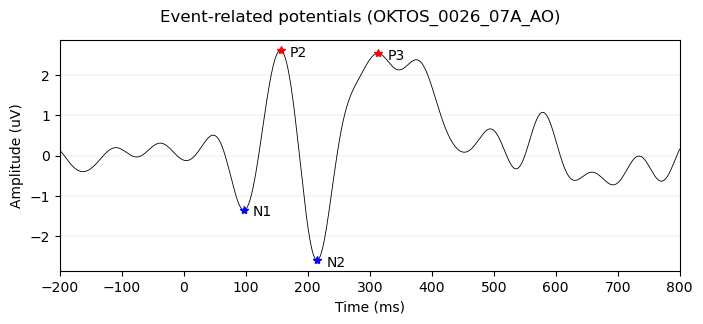

ERPs have been found and added to the dataframe for OKTOS_0026_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819


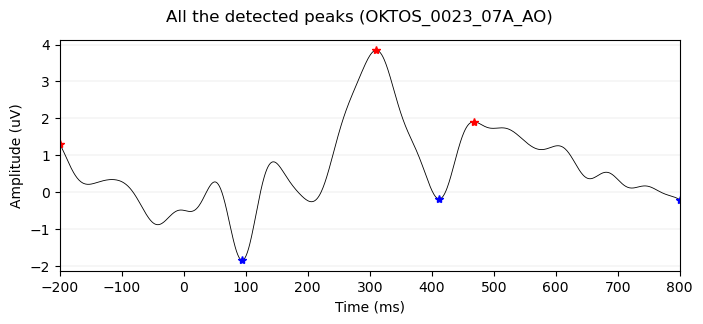

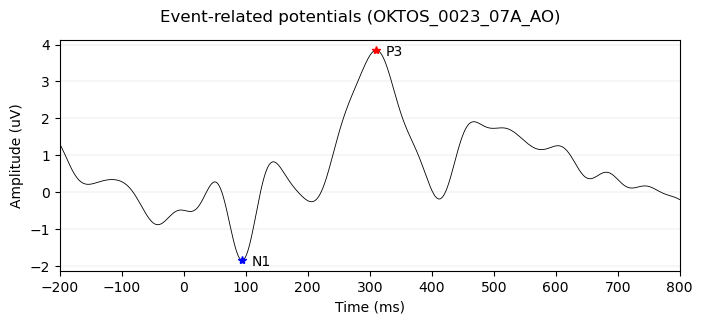

ERPs have been found and added to the dataframe for OKTOS_0023_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820


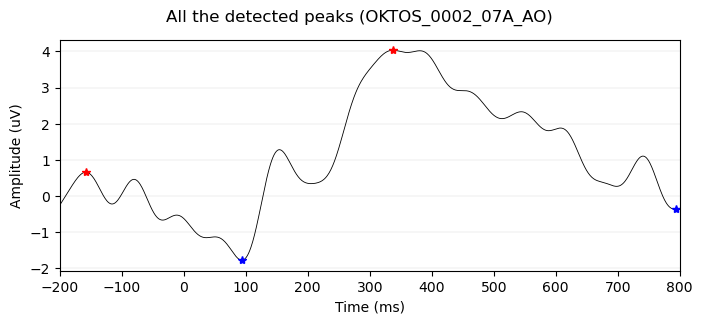

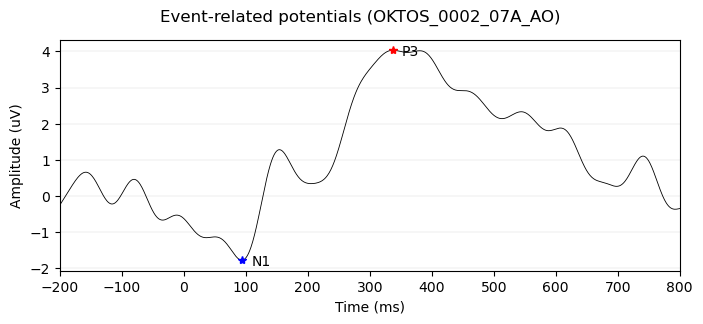

ERPs have been found and added to the dataframe for OKTOS_0002_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096


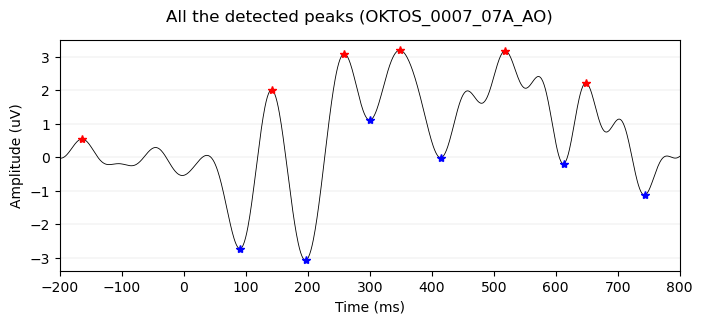

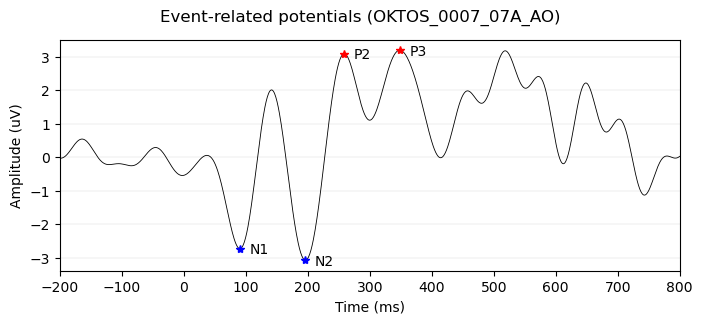

Changing time window parameters for OKTOS_0007_07A_AO
Changing P2 with new time window: [100, 200, 1]


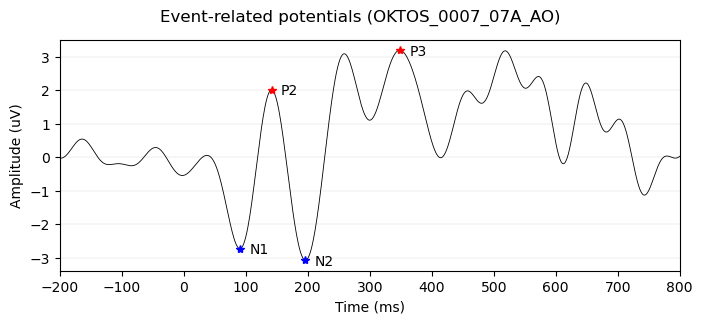

Changing time window parameters for OKTOS_0007_07A_AO
Changing P3 with new time window: [200, 300, 1]


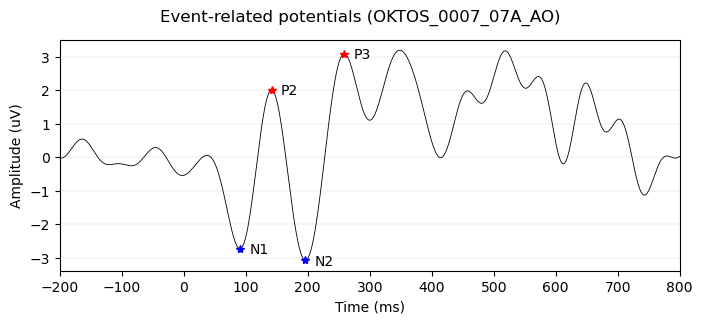

ERPs have been found and added to the dataframe for OKTOS_0007_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916


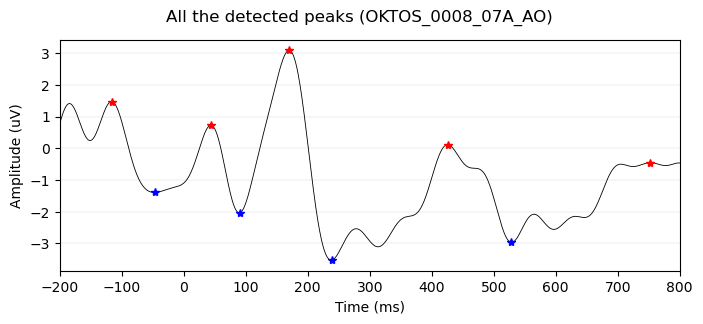

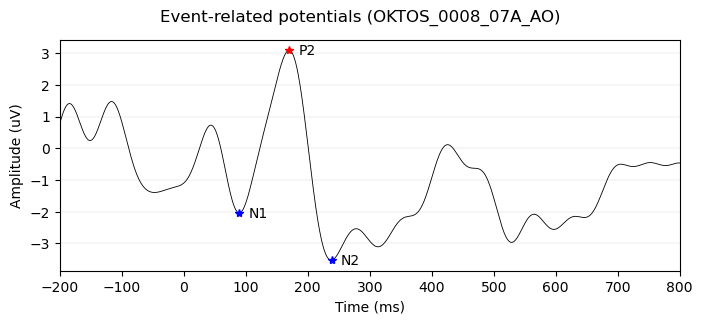

Changing time window parameters for OKTOS_0008_07A_AO
Changing P3 with new time window: [300, 600, 1]


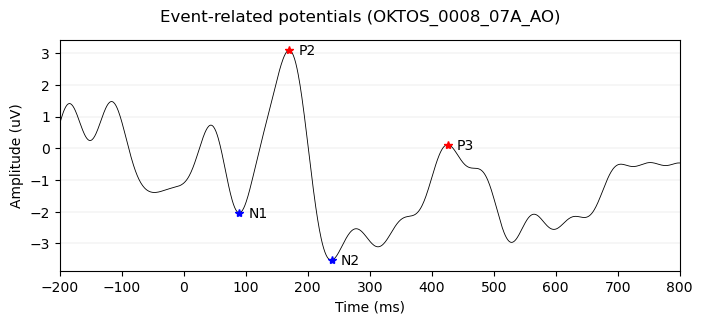

ERPs have been found and added to the dataframe for OKTOS_0008_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


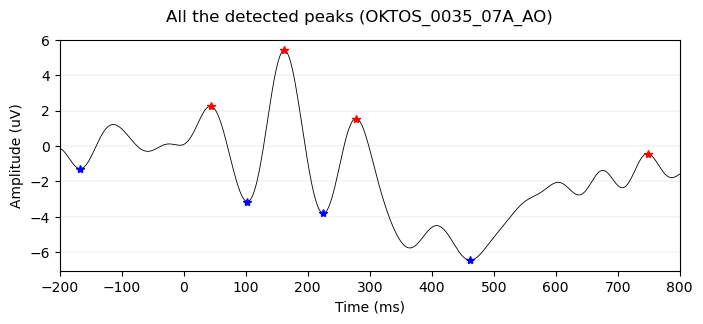

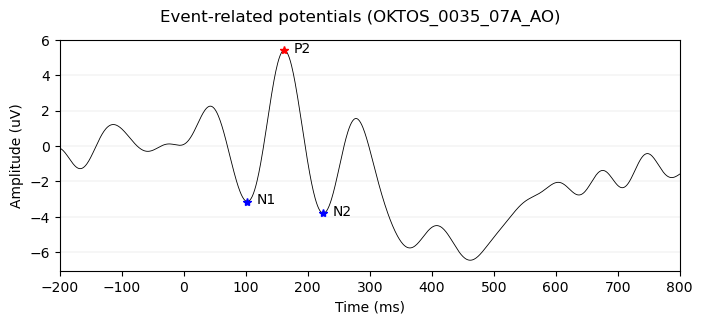

Changing time window parameters for OKTOS_0035_07A_AO
Changing P3 with new time window: [200, 400, 1]


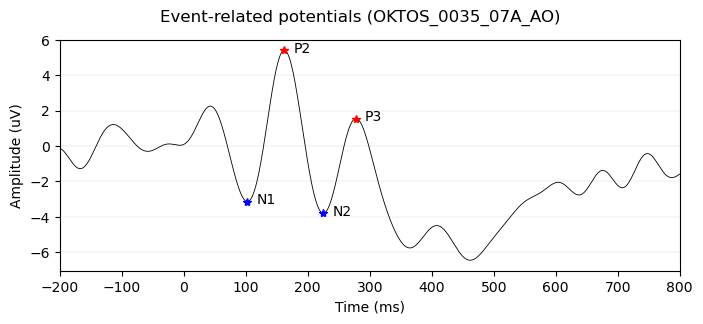

ERPs have been found and added to the dataframe for OKTOS_0035_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


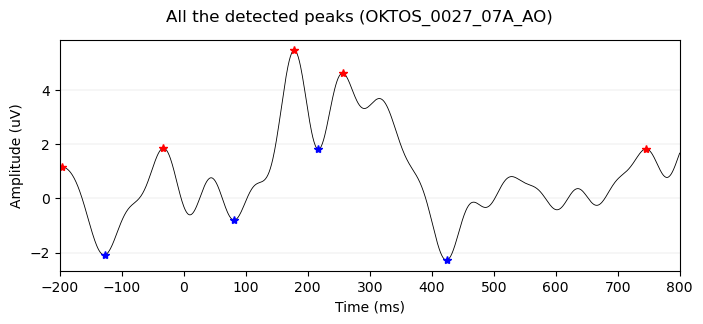

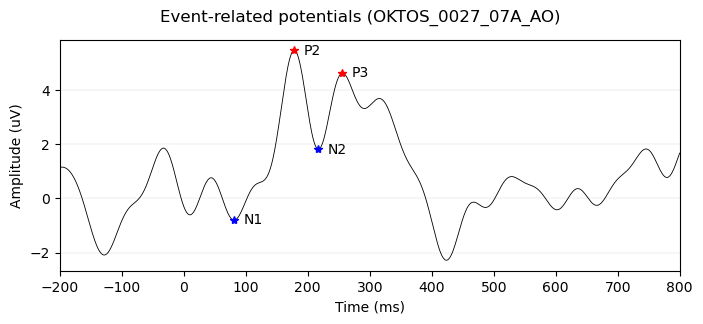

ERPs have been found and added to the dataframe for OKTOS_0027_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


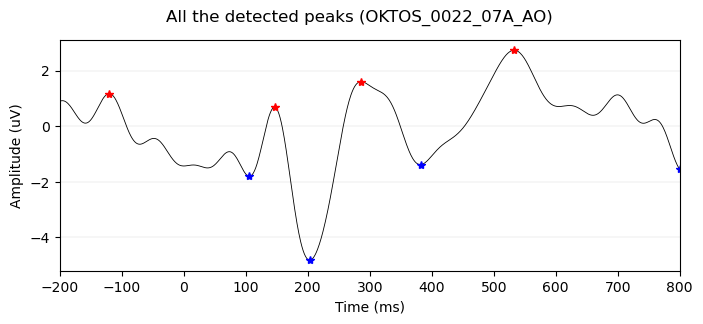

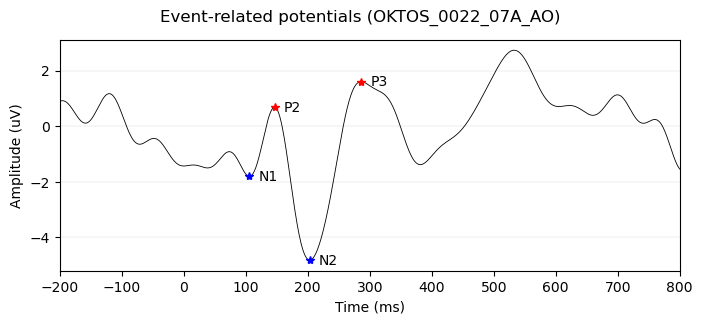

ERPs have been found and added to the dataframe for OKTOS_0022_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


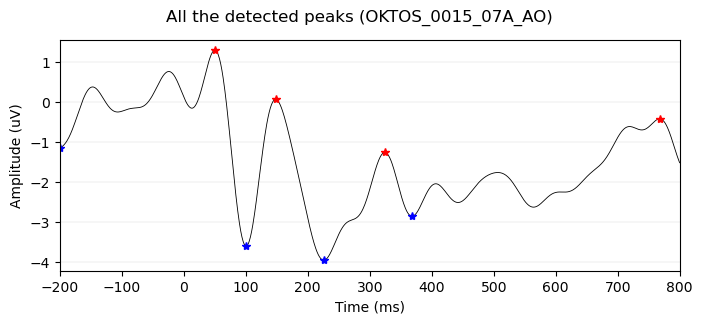

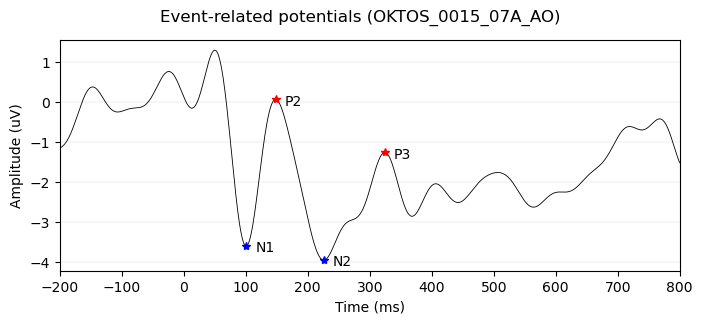

ERPs have been found and added to the dataframe for OKTOS_0015_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


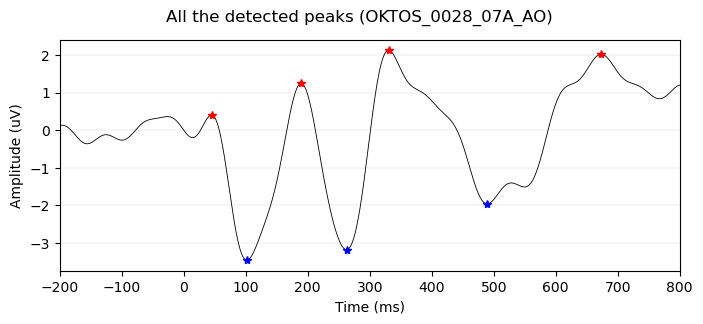

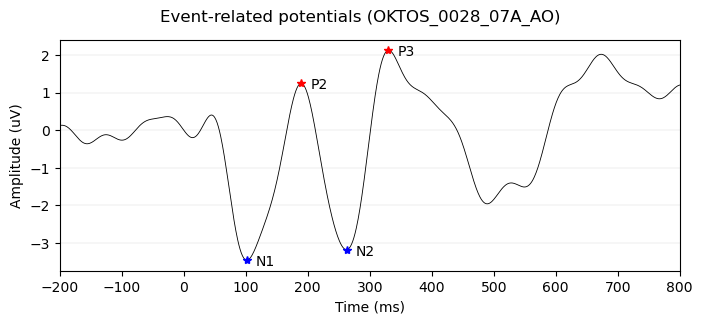

ERPs have been found and added to the dataframe for OKTOS_0028_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


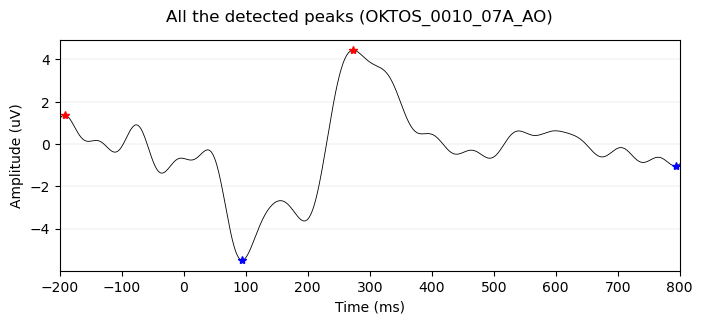

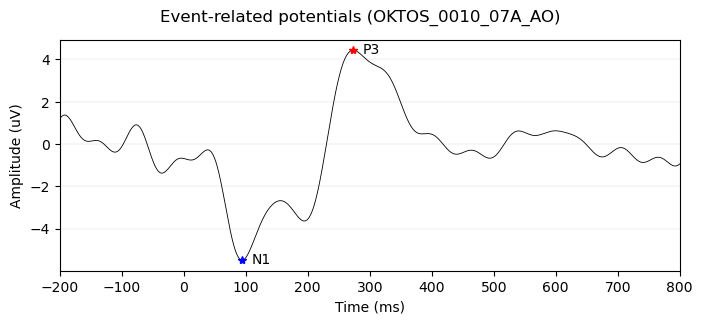

ERPs have been found and added to the dataframe for OKTOS_0010_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


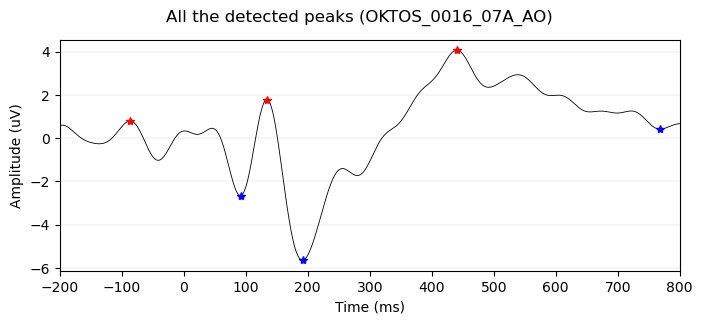

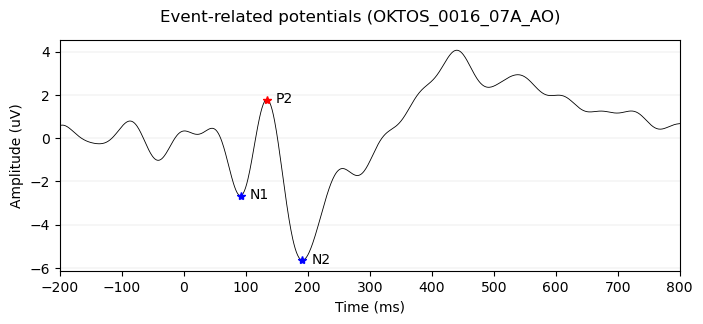

Changing time window parameters for OKTOS_0016_07A_AO
Changing P3 with new time window: [300, 600, 1]


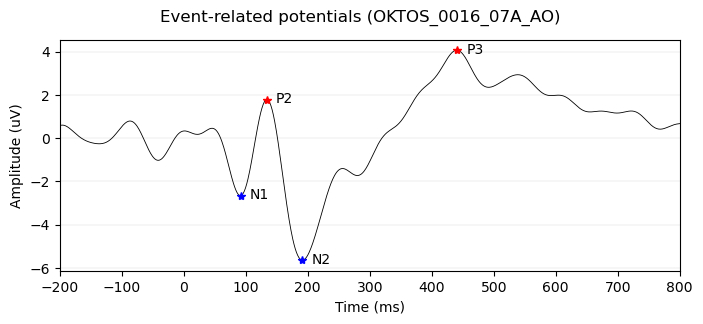

ERPs have been found and added to the dataframe for OKTOS_0016_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


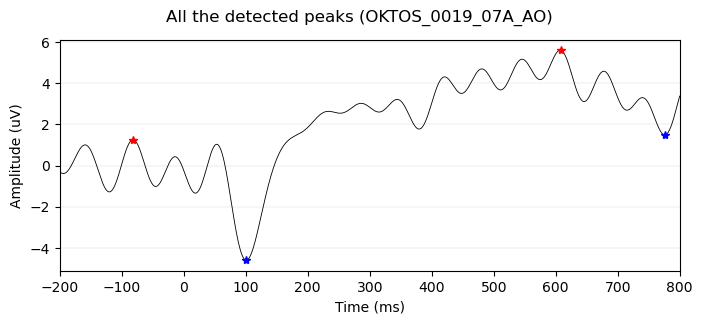

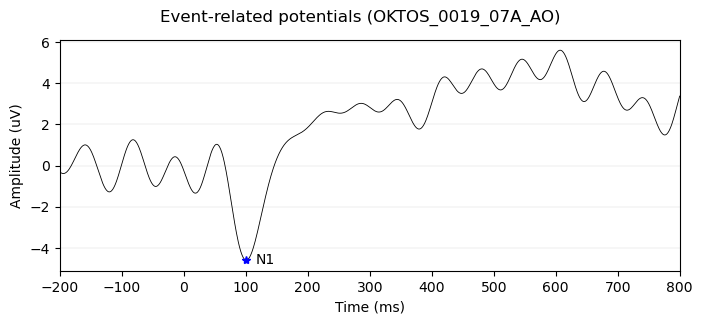

ERPs have been found and added to the dataframe for OKTOS_0019_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


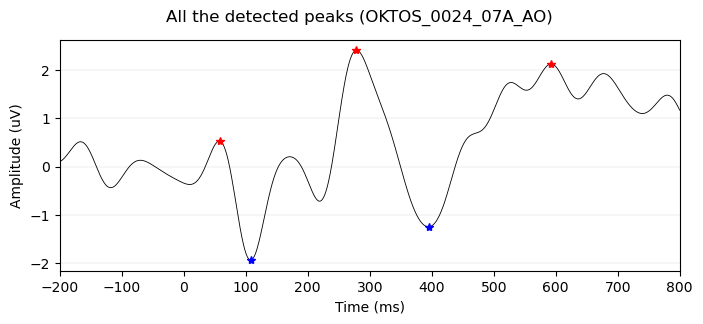

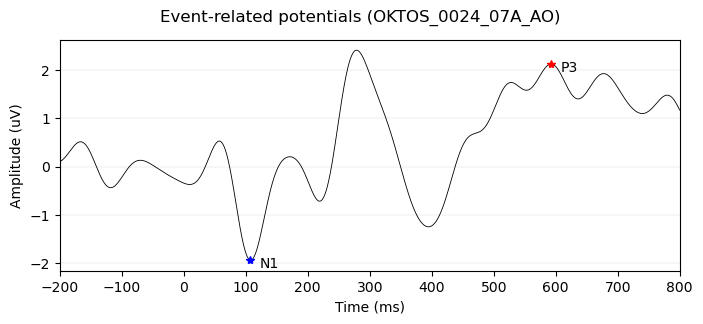

ERPs have been found and added to the dataframe for OKTOS_0024_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


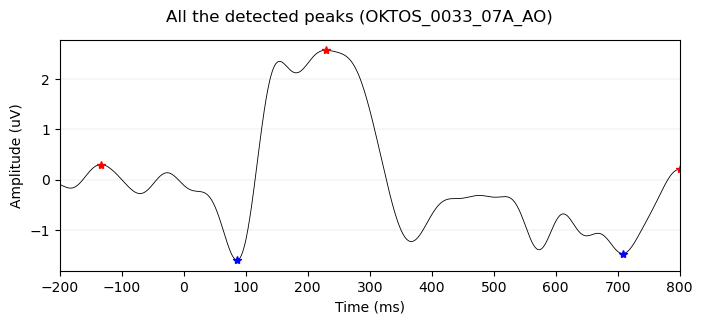

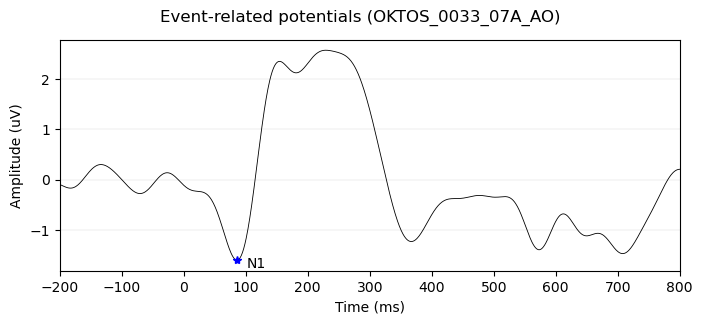

ERPs have been found and added to the dataframe for OKTOS_0033_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


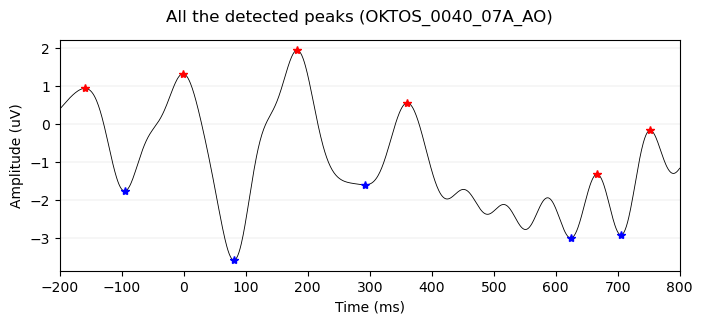

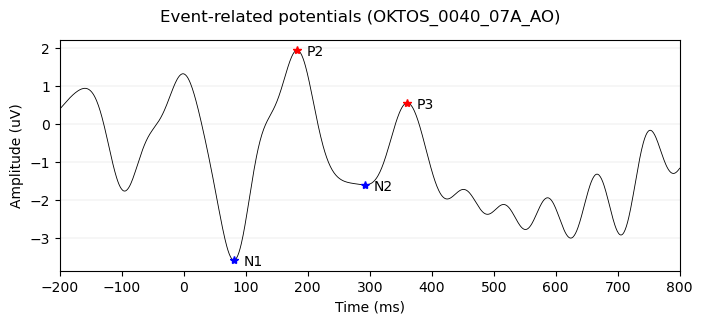

ERPs have been found and added to the dataframe for OKTOS_0040_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


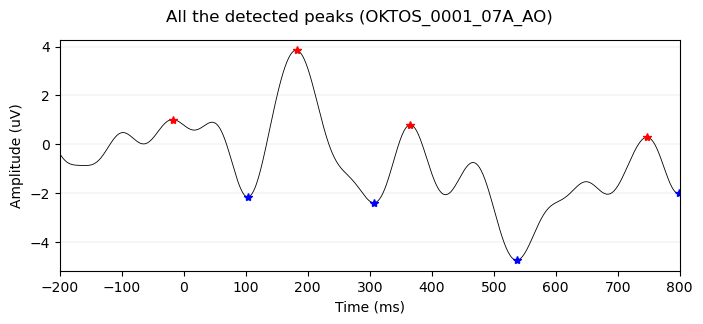

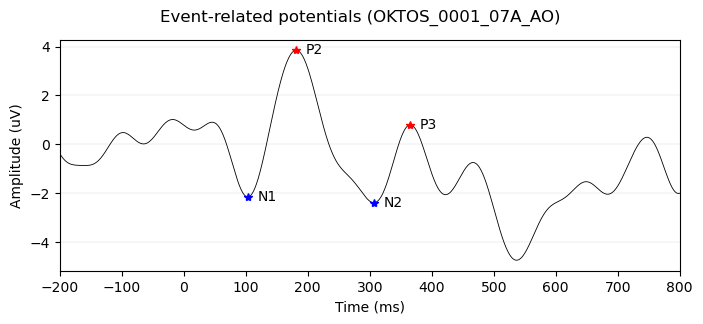

ERPs have been found and added to the dataframe for OKTOS_0001_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


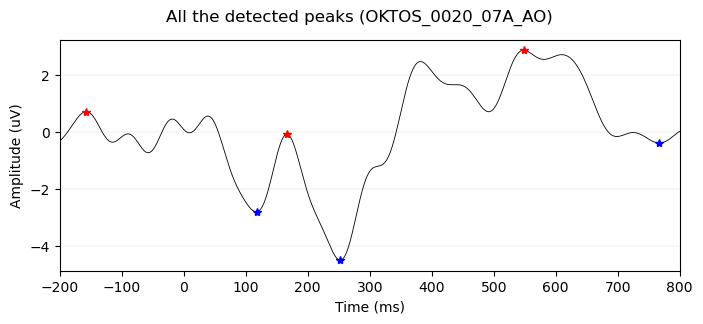

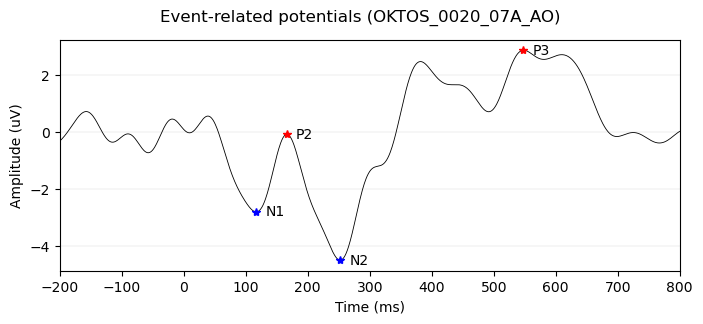

ERPs have been found and added to the dataframe for OKTOS_0020_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


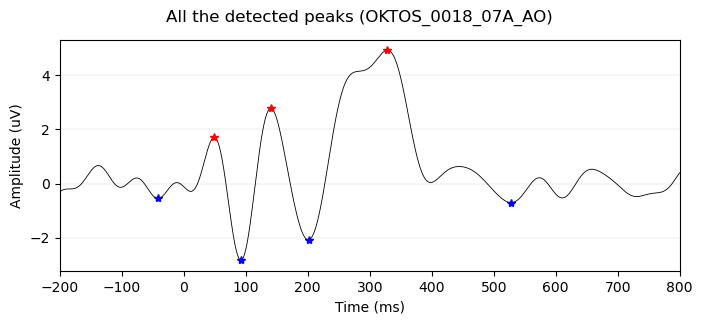

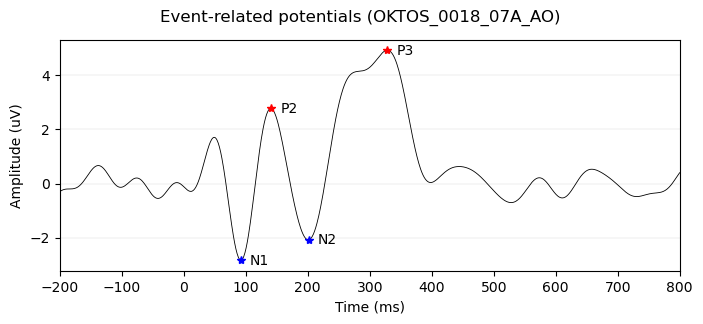

ERPs have been found and added to the dataframe for OKTOS_0018_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


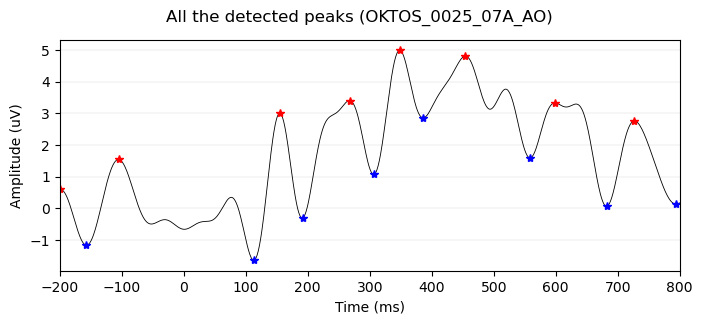

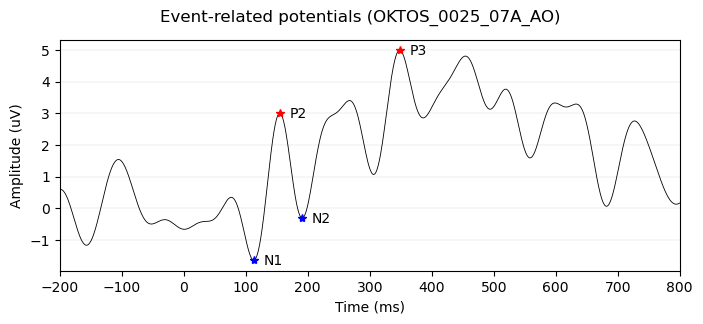

ERPs have been found and added to the dataframe for OKTOS_0025_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


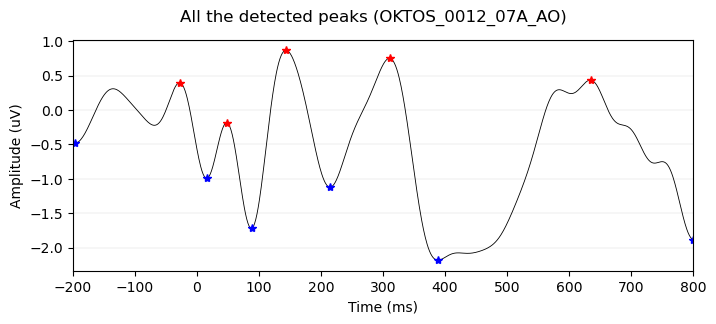

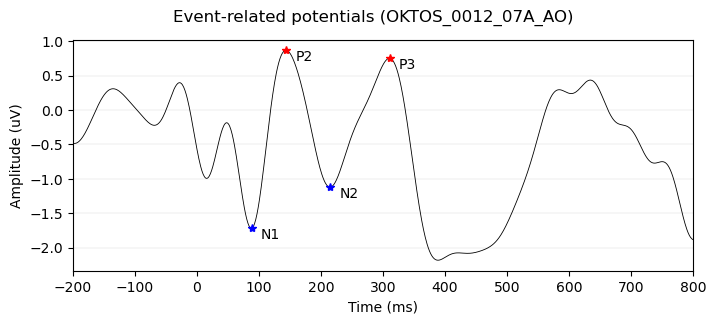

ERPs have been found and added to the dataframe for OKTOS_0012_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


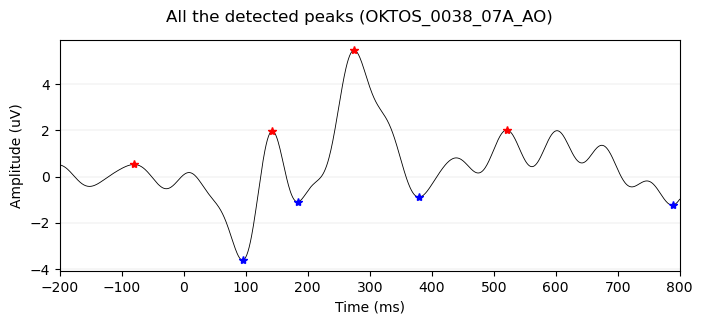

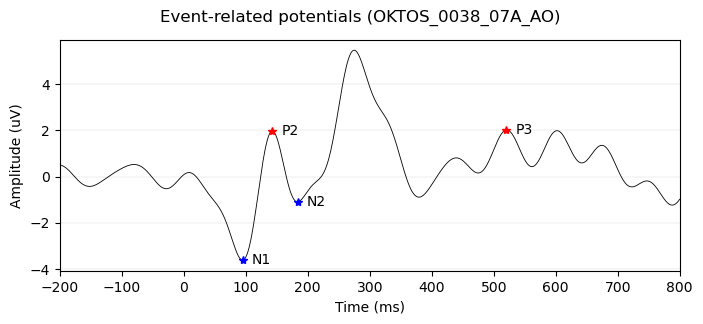

Changing time window parameters for OKTOS_0038_07A_AO
Changing P3 with new time window: [200, 400, 1]


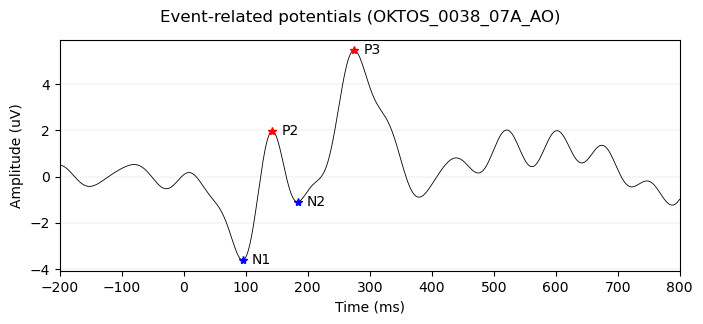

ERPs have been found and added to the dataframe for OKTOS_0038_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,NaN,197.265625,NaN,341.796875,NaN,-5.008666,NaN,4.148438
OKTOS_0003_07A_AO,95.703125,206.054688,153.320312,320.312500,-4.267366,-2.698554,1.207446,3.606869
OKTOS_0006_07A_AO,122.070312,237.304688,181.640625,383.789062,-2.174203,-1.247142,3.289813,4.293155
OKTOS_0011_07A_AO,99.609375,226.562500,162.109375,NaN,-2.963009,-4.944110,2.027330,NaN
OKTOS_0029_07A_AO,99.609375,253.906250,151.367188,466.796875,-1.528149,-2.548632,1.866536,2.844553
OKTOS_0026_07A_AO,96.679688,214.843750,156.250000,313.476562,-1.352378,-2.595457,2.619463,2.540819
OKTOS_0023_07A_AO,93.750000,NaN,NaN,310.546875,-1.837489,NaN,NaN,3.845820
OKTOS_0002_07A_AO,93.750000,NaN,NaN,336.914062,-1.773711,NaN,NaN,4.035096
OKTOS_0007_07A_AO,90.820312,196.289062,141.601562,258.789062,-2.723914,-3.066875,2.011429,3.088916
OKTOS_0008_07A_AO,89.843750,238.281250,169.921875,425.781250,-2.035814,-3.527201,3.090020,0.114281


In [551]:

# Define these!
erp_wins = {'N1':[40, 170, -1],
            'N2':[180, 350, -1],
            'P2':[100, 260, 1],
            'P3':[270, 500, 1]}
channel_picks = ['Cz']
event_list = ['target after 1 standard','target after 3 standards','target after 5 standards',
            'target after 7 standards','target after 9 standards','target after 11 standards']

# Pre-defined variables
df_erps = pd.DataFrame()
evoked_signal = [None]*len(file_dirs)

dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = read_files(dir_inprogress,"_clean-epo.fif")

for i in range(len(file_dirs)):
    erp_wins_temp = erp_wins
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)
    
    # Create an averaged evoked object from epochs for 
    evoked_signal[i] = epochs[event_list].average(picks=channel_picks)

    # Find all the peaks in the evoked signal
    minpeak_times, minpeak_mags, maxpeak_times, maxpeak_mags = find_all_peaks(evoked_signal[i], epochs,
                                                                              thresh=None, # thresh seems not to work
                                                                              subject_name=subject_names[i], verbose=False, plot=True)
    
    # Identify which peaks are which ERPs based on the pre-defined ERP time window dictionary
    erp_peaks, not_erp_peaks = identify_erps(evoked_signal[i],erp_wins_temp,minpeak_times,minpeak_mags,maxpeak_times,maxpeak_mags,
                                             subject_name=subject_names[i],verbose=False,plot=True,savefig=True)

    # After visual inspection, it's possible to define the time windows to look for the peak
    while input('Do you need to do any manual time window changes? (leave empty if "no")') != '':
        print('Changing time window parameters for {}'.format(subject_names[i]))
        new_time_win = [None,None,None]

        erp_tochange = input('What ERP time window you want to change (e.g., N1)?')

        for l in range(len(new_time_win)):
            new_time_win[l] = int(input('Enter time window parameter {} for {} (e.g., [50, 120, -1])'.format(l,erp_tochange)))

        erp_wins_temp[erp_tochange] = new_time_win

        print('Changing',erp_tochange,'with new time window:',str(new_time_win))

        erp_peaks, not_erp_peaks = identify_erps(evoked_signal[i],erp_wins_temp,minpeak_times,minpeak_mags,maxpeak_times,maxpeak_mags,
                                                 subject_name=subject_names[i],verbose=False,plot=True,savefig=True)

    df_erps_temp = erp_dict_to_df(erp_peaks,erp_wins_temp,subject_names[i])
    df_erps = pd.concat([df_erps, df_erps_temp])

    print('ERPs have been found and added to the dataframe for {}'.format(subject_names[i]))
    display(df_erps)


In [552]:
create_results_folders(exp_folder=exp_folder,results_foldername=results_foldername)

df_erps.to_excel(r"{}/{}_{}_grandaverage_erps.xlsx".format(results_foldername,exp_condition,channel_picks))